# Table of Contents:
* [0 -Importing Libraries](#0)
* [1 - Read in df](#1)
* [2 - PACEU](#2)
* [3 - Sensitivy Analysis](#3)

# 0) Imports <a class="anchor" id="0"></a>

In [4]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ast  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from tqdm import tqdm
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# 1) Read in df <a class="anchor" id="1"></a>

In [5]:
txt_file = 'small.txt'

In [6]:
# Initialize an empty list to store the df
df = []

# Define keys based on the train_train_train_train_train_dfset format
keys = ['#*', '#@', '#t', '#c', '#index', '#%', '#!']

# Open the file and read the contents
with open(txt_file, 'r', encoding='ISO-8859-1') as file:
    current_paper = {}
    for line in file:
        line = line.strip()
        if line.startswith('#*'):
            # New paper starts; save the previous one if it exists
            if current_paper:
                df.append(current_paper)
                current_paper = {}
            current_paper['Title'] = line[2:].strip()
        elif line.startswith('#@'):
            current_paper['Authors'] = line[2:].strip()
        elif line.startswith('#t'):
            current_paper['Year'] = line[2:].strip()
        elif line.startswith('#c'):
            current_paper['Venue'] = line[2:].strip()
        elif line.startswith('#index'):
            current_paper['Index ID'] = line[6:].strip()
        elif line.startswith('#%'):
            if 'References' not in current_paper:
                current_paper['References'] = []
            current_paper['References'].append(line[2:].strip())
        elif line.startswith('#!'):
            current_paper['Abstract'] = line[2:].strip()
        elif line.isdigit() and current_paper:  # Handle end of current paper
            df.append(current_paper)
            current_paper = {}
    # Add the last paper
    if current_paper:
        df.append(current_paper)

# Convert list of dicts to dfFrame
df = pd.DataFrame(df)

# Replacing missing keys with None which becomes NaN in dfFrame
for key in ['Title', 'Authors', 'Year', 'Venue', 'Index ID', 'References', 'Abstract']:
    if key not in df.columns:
        df[key] = None

In [7]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df[(df['Year']>1990) & (df['Year']<2010)]
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
# Apply the function to the dfFrame column
df['References'] = df['References'].apply(
    lambda x: [int(i) for i in x] if isinstance(x, list) else x
)

Last Cited Year (for SIR)

In [8]:
# Creating a dictionary from the dfFrame assuming 'Index ID' and 'Year' are columns in your dfFrame
year_dict = df.set_index('Index ID')['Year'].to_dict()

def get_last_cited_year(ref_ids):
    if not isinstance(ref_ids, list):
        return np.nan
    # Filter and collect years where reference IDs exist in year_dict
    years = [year_dict.get(int(ref_id)) for ref_id in ref_ids if int(ref_id) in year_dict]
    return max(years) if years else np.nan

# Apply the function to the 'References' column to compute the 'Last Cited Year'
df['Last Cited Year'] = df['References'].apply(get_last_cited_year)
df["Venue"] = df["Venue"].astype(str)
df['Venue'] = df['Venue'].replace('', np.nan)
df["References Count"] = df["References"].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [9]:
# Calculate total authors
df['Authors'] = df['Authors'].fillna('')  # Fill empty strings where there are no authors
unique_authors = set()
df['Authors'].apply(lambda x: unique_authors.update(x.split(',')) if x else None)
total_authors = len(unique_authors) - 1 if '' in unique_authors else len(unique_authors)

# Fill missing Venue values with "Unknown"
df['Venue'] = df['Venue'].fillna("Unknown")

In [10]:
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')

# Convert 'References' from string representation of list to actual list
def safe_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []  # Return an empty list if there's any error

df['References'] = df['References'].apply(safe_eval)

# Creating a dictionary of publication years for quick lookup
publication_years = df.set_index('Index ID')['Year'].to_dict()

# Function to count citations within three years
def count_citations_within_3_years(row):
    if isinstance(row['References'], list):  # Ensure that the data is list
        citation_years = [publication_years.get(int(ref)) for ref in row['References'] if publication_years.get(int(ref)) is not None]
        return sum((year is not None and (row['Year'] <= year <= row['Year'] + 3)) for year in citation_years)
    return 0  # Return 0 if References is not a list

# Apply the function
df['citation_count_within_3_years'] = df.apply(count_citations_within_3_years, axis=1)

In [11]:
# import pandas as pd
# import numpy as np

# # Assuming df is your DataFrame and it's correctly loaded and prepared

# # Define high-impact venues using a set for faster membership testing
# high_impact_venues = {
#     "Nature", "Science", "IEEE Transactions on Information Forensics and Security",
#     "Journal of Machine Learning Research", "Communications of the ACM",
#     "IEEE Transactions on Knowledge and Data Engineering", "Journal of the ACM",
#     "Proceedings of the IEEE", "ACM Transactions on Algorithms",
#     "IEEE Trans. Parallel Distrib. Syst.", "IEEE Trans. Evolutionary Computation",
#     "Journal of Computational Physics", "Journal of the American Society for Information Science and Technology"
# }

# # Vectorized high-impact check
# df['High_Impact'] = df['Venue'].isin(high_impact_venues)
# df['References_Is_List'] = df['References'].apply(lambda x: isinstance(x, list))

# # Create expanded DataFrame without loops
# years_range = range(df['Year'].min(), 2010)
# index_years = pd.MultiIndex.from_product([df.index, years_range], names=['original_index', 'Simulation_Year'])
# expanded_df = df.loc[index_years.get_level_values('original_index')].copy()
# expanded_df['Simulation_Year'] = index_years.get_level_values('Simulation_Year')
# expanded_df['State'] = np.where(expanded_df['Simulation_Year'] == expanded_df['Year'], 'Published', np.nan)

# # Initialize state based on conditions
# is_exposed = (expanded_df['High_Impact'] & (expanded_df['citation_count_within_3_years'] >= 5))
# expanded_df.loc[expanded_df['State'] == 'Published' & is_exposed, 'State'] = 'Exposed'

# # Forward fill states
# expanded_df.sort_values(by=['Index ID', 'Simulation_Year'], inplace=True)
# expanded_df['State'] = expanded_df.groupby('Index ID')['State'].ffill()

# # State transitions using vectorized conditions
# conditions = [
#     (expanded_df['State'] == 'Published') & (expanded_df['citation_count_within_3_years'] >= 5) & expanded_df['References_Is_List'],
#     (expanded_df['State'] == 'Exposed') & ((expanded_df['Simulation_Year'] - expanded_df['Year']) > 3)
# ]
# choices = ['Exposed', 'Archived']
# expanded_df['State'] = np.select(conditions, choices, default=expanded_df['State'])

# # Transition rates calculation simplified and vectorized
# def calculate_transition_rates(data, from_state, to_state):
#     data['Next_Year'] = data['Simulation_Year'] + 1
#     next_state = data['State'].shift(-1)  # Assuming data is already sorted properly
#     transitions = (data['State'] == from_state) & (next_state == to_state)
#     rate = transitions.sum() / (data['State'] == from_state).sum()
#     return rate if not np.isnan(rate) else 0

# # Calculate rates
# lambda_PE = calculate_transition_rates(expanded_df, 'Published', 'Exposed')
# print(f"Estimated lambda_PE: {lambda_PE}")


In [12]:
# Define high-impact venues
high_impact_venues = [
    "Nature", "Science", "IEEE Transactions on Information Forensics and Security",
    "Journal of Machine Learning Research", "Communications of the ACM",
    "IEEE Transactions on Knowledge and Data Engineering", "Journal of the ACM",
    "Proceedings of the IEEE", "ACM Transactions on Algorithms",
    "IEEE Trans. Parallel Distrib. Syst.", "IEEE Trans. Evolutionary Computation",
    "Journal of Computational Physics", "Journal of the American Society for Information Science and Technology"
]

# Initialize DataFrame
expanded_df = pd.DataFrame([
    {**row, 'Simulation_Year': year, 'State': 'Published' if year == row['Year'] else np.nan}
    for _, row in df.iterrows()
    for year in range(row['Year'], max(df['Year']) + 1)],
    ignore_index=True
)

# Check if venues are high-impact and references are a list
expanded_df['High_Impact'] = expanded_df['Venue'].isin(high_impact_venues)
expanded_df['References_Is_List'] = expanded_df['References'].apply(lambda x: isinstance(x, list))

# Update initial states
def initial_state(row):
    if row['High_Impact'] and row['citation_count_within_3_years'] >= 5:
        return 'High Impact'
    elif row['High_Impact']:
        return 'Exposed'
    return 'Published'

expanded_df['State'] = expanded_df.apply(lambda row: initial_state(row) if row['Simulation_Year'] == row['Year'] else np.nan, axis=1)

# Forward fill states
expanded_df.sort_values(by=['Index ID', 'Simulation_Year'], inplace=True)
expanded_df['State'] = expanded_df.groupby('Index ID')['State'].ffill()

# Define conditions for transitions
conditions = [
    (expanded_df['State'] == 'Published') & (expanded_df['References_Is_List']),
    (expanded_df['State'] == 'Exposed') & (expanded_df['citation_count_within_3_years'] >= 5),
    (expanded_df['State'] == 'Exposed') & ((expanded_df['Simulation_Year'] - expanded_df['Year']) > 3) & (expanded_df['citation_count_within_3_years'] < 5)
]
choices = ['Cited', 'High Impact', 'Archived']
expanded_df['State'] = np.select(conditions, choices, default=expanded_df['State'])

# Convert to Dask DataFrame for parallel processing
dask_df = dd.from_pandas(expanded_df, npartitions=10)

# Apply vectorized state updates and compute results using Dask
with ProgressBar():
    final_active_df = dask_df.compute()

# Ensure the DataFrame is correctly sorted and all operations are reflected
final_active_df.sort_values(by=['Index ID', 'Simulation_Year'], inplace=True)

In [ ]:
final_df = pd.concat([final_active_df, expanded_df[~expanded_df.index.isin(final_active_df.index)]])

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_29212\2867724789.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_active_df, expanded_df[~expanded_df.index.isin(final_active_df.index)]])


In [ ]:
final_df.to_csv('final_df.csv', index=False)

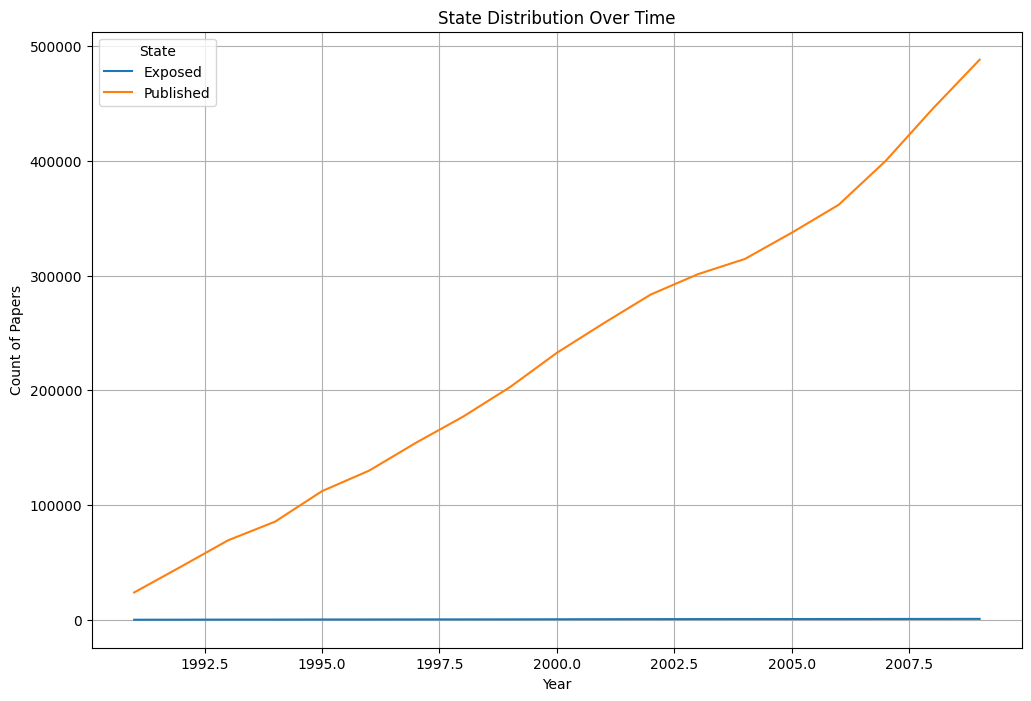

In [ ]:
# Group by 'Simulation_Year' and count occurrences of each state
state_counts_over_time = final_df.groupby(['Simulation_Year', 'State']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 8))
for state in state_counts_over_time.columns:
    plt.plot(state_counts_over_time.index, state_counts_over_time[state], label=state)

plt.title('State Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Count of Papers')
plt.legend(title='State')
plt.grid(True)
plt.show()

# 2) PACEU model <a class="anchor" id="2"></a>

In [ ]:
df_ = df.copy()

In [ ]:
# Reset index
df = final_df.sample(frac=1).reset_index(drop=True)

In [ ]:
final_df.iloc[:100].to_csv('final_df_100.csv', index=False)

In [ ]:
min_year = 1990
test_year = 2007
max_year = 2009

In [ ]:
# Time-based split
train_df = df[(df['Year'] <= test_year) & (df['Year'] > min_year)]
test_df = df[df['Year'] > test_year]

## 2.1) Define model and calculate transition rates

In [ ]:
def citation_model(y, t, lambda_PE, lambda_EC, lambda_CH, gamma_HA):
    P, E, C, H = y
    dP_dt = -lambda_PE * P  # Transition from Published to Exposed
    dE_dt = lambda_PE * P - lambda_EC * E  # Transition from Exposed to Cited
    dC_dt = lambda_EC * E - lambda_CH * C  # Transition from Cited to High Impact
    dH_dt = lambda_CH * C - gamma_HA * H  # High Impact becoming Archived
    return [dP_dt, dE_dt, dC_dt, dH_dt]

In [ ]:
def calculate_transition_rates(data, from_state, to_state):
    # Ensure the DataFrame includes the next year's state for comparison
    data['Next_Year'] = data['Year'] + 1
    data_next_year = data[['Index ID', 'Next_Year', 'State']].rename(columns={'Next_Year': 'Year', 'State': 'Next_State'})
    merged = data.merge(data_next_year, on=['Index ID', 'Year'], how='left')
    
    # Calculate transitions based on the new state definitions
    transitions = merged[(merged['State'] == from_state) & (merged['Next_State'] == to_state)]
    total_from_state = merged[merged['State'] == from_state]
    
    # Avoid division by zero
    rate = len(transitions) / len(total_from_state) if len(total_from_state) > 0 else 0
    return rate

# Example usage
lambda_PE = calculate_transition_rates(train_df, 'Published', 'Exposed')
lambda_EC = calculate_transition_rates(train_df, 'Exposed', 'Cited')
lambda_CH = calculate_transition_rates(train_df, 'Cited', 'High Impact')
gamma_HA = calculate_transition_rates(train_df, 'High Impact', 'Archived')

print(f"Estimated lambda_PE: {lambda_PE}")
print(f"Estimated lambda_EC: {lambda_EC}")
print(f"Estimated lambda_CH: {lambda_CH}")
print(f"Estimated gamma_HA: {gamma_HA}")


C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_29212\1082360059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Next_Year'] = data['Year'] + 1


C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_29212\1082360059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Next_Year'] = data['Year'] + 1
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_29212\1082360059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Next_Year'] = data['Year'] + 1
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_29212\1082360059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Estimated lambda_PE: 0.0
Estimated lambda_EC: 0.0
Estimated lambda_CH: 0
Estimated gamma_HA: 0


In [ ]:
# # Debug function to understand why transitions aren't happening
# def debug_transitions(row):
#     if row['State'] == 'Published' and row['citation_count_within_3_years'] >= 5 and isinstance(row['References'], list):
#         if not is_high_impact(row['Venue']):
#             return "Not High Impact"
#         return "Transition to Exposed"
#     if row['State'] == 'Exposed' and (row['Simulation_Year'] - row['Year'] > 3):
#         if row['citation_count_within_3_years'] >= 5:
#             return "Stay Exposed"
#         return "Transition to Archived"
#     return "No Transition"

# # Apply the debug function to the DataFrame
# expanded_df['Debug_Info'] = expanded_df.apply(debug_transitions, axis=1)

# # Analyze the results
# transition_counts = expanded_df['Debug_Info'].value_counts()
# print(transition_counts)


### For R0

In [ ]:
def calculate_transition_probability(data, from_state, to_state):
    # Filter data for relevant transitions
    relevant_data = data[data['State'] == from_state]
    transitions = relevant_data[relevant_data['Next_State'] == to_state]

    # Calculate transition probability
    probability = len(transitions) / len(relevant_data) if len(relevant_data) > 0 else 0
    return probability

# Calculate the probability of moving from Exposed to High Impact directly
probability_EH = calculate_transition_probability(expanded_df, 'Exposed', 'High Impact')
print(f"Probability of moving from Exposed to High Impact: {probability_EH:.2f}")

KeyError: 'Next_State'

## 2.2) Set initial conditions and run on the training set

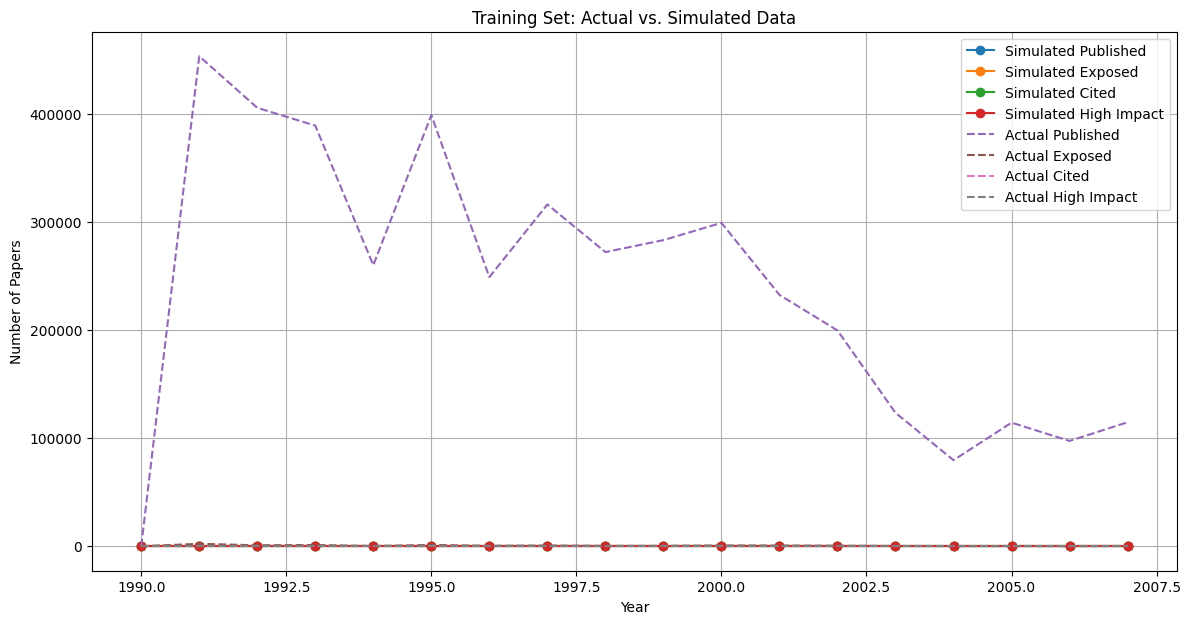

Mean Squared Error for Training Data: 18144244040.430557


In [ ]:
# lambda_PE, lambda_EC, lambda_CH, gamma_HA = 0.1, 0.1, 0.1, 0.1

# Initial conditions based on the first year data in training set
initial_conditions_train = [
    train_df[train_df['Year'] == min_year]['State'].value_counts().get('Published', 0),
    train_df[train_df['Year'] == min_year]['State'].value_counts().get('Exposed', 0),
    train_df[train_df['Year'] == min_year]['State'].value_counts().get('Cited', 0),
    train_df[train_df['Year'] == min_year]['State'].value_counts().get('High Impact', 0)
]

# Time points
time_points_train = np.arange(min_year, test_year + 1)

# Solve ODE for training data
results_train = odeint(citation_model, initial_conditions_train, time_points_train, args=(lambda_PE, lambda_EC, lambda_CH, gamma_HA))

# Gather actual data for training period
actual_data_train = [
    [train_df[train_df['Year'] == year]['State'].value_counts().get('Published', 0),
     train_df[train_df['Year'] == year]['State'].value_counts().get('Exposed', 0),
     train_df[train_df['Year'] == year]['State'].value_counts().get('Cited', 0),
     train_df[train_df['Year'] == year]['State'].value_counts().get('High Impact', 0)] for year in time_points_train
]

# Calculate MSE for training
mse_train = np.mean((np.array(actual_data_train) - results_train)**2)

# Plot training results
plt.figure(figsize=(14, 7))
plt.plot(time_points_train, results_train, marker='o', label=['Simulated Published', 'Simulated Exposed', 'Simulated Cited', 'Simulated High Impact'])
plt.plot(time_points_train, np.array(actual_data_train), linestyle='--', label=['Actual Published', 'Actual Exposed', 'Actual Cited', 'Actual High Impact'])
plt.title('Training Set: Actual vs. Simulated Data')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Squared Error for Training Data: {mse_train}")

## 2.3) Test set

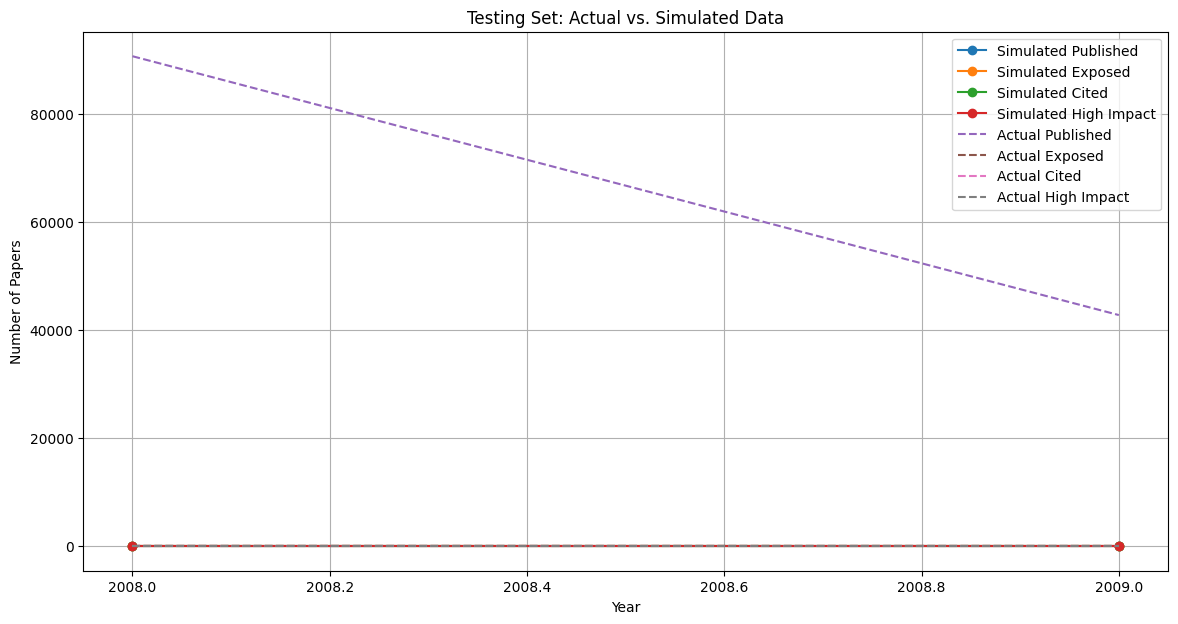

Mean Squared Error for Testing Data: 1256838317.25


In [ ]:
# Initial conditions based on last year of training data
initial_conditions_test = results_train[-1, :]

# Time points for testing data
time_points_test = np.arange(test_year + 1, max_year + 1)

# Solve ODE for testing data
results_test = odeint(citation_model, initial_conditions_test, time_points_test, args=(lambda_PE, lambda_EC, lambda_CH, gamma_HA))

# Gather actual data for testing period
actual_data_test = [
    [test_df[test_df['Year'] == year]['State'].value_counts().get('Published', 0),
     test_df[test_df['Year'] == year]['State'].value_counts().get('Exposed', 0),
     test_df[test_df['Year'] == year]['State'].value_counts().get('Cited', 0),
     test_df[test_df['Year'] == year]['State'].value_counts().get('High Impact', 0)] for year in time_points_test
]

# Calculate MSE for testing
mse_test = np.mean((np.array(actual_data_test) - results_test)**2)

# Plot testing results
plt.figure(figsize=(14, 7))
plt.plot(time_points_test, results_test, marker='o', label=['Simulated Published', 'Simulated Exposed', 'Simulated Cited', 'Simulated High Impact'])
plt.plot(time_points_test, np.array(actual_data_test), linestyle='--', label=['Actual Published', 'Actual Exposed', 'Actual Cited', 'Actual High Impact'])
plt.title('Testing Set: Actual vs. Simulated Data')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Squared Error for Testing Data: {mse_test}")

# 3) Sensitivity <a class="anchor" id="3"></a>

In [ ]:
# Define a range for each parameter
lambda_PE_values = np.linspace(0.05, 0.15, 5)
lambda_EC_values = np.linspace(0.02, 0.08, 5)
lambda_CH_values = np.linspace(0.01, 0.05, 5)
gamma_HA_values = np.linspace(0.005, 0.015, 5)

# Store results
results = []

for lambda_PE in lambda_PE_values:
    for lambda_EC in lambda_EC_values:
        for lambda_CH in lambda_CH_values:
            for gamma_HA in gamma_HA_values:
                # Solve ODE with current parameters
                results_sim = odeint(citation_model, initial_conditions_train, time_points_train, args=(lambda_PE, lambda_EC, lambda_CH, gamma_HA))
                mse_sim = np.mean((np.array(actual_data_train) - results_sim)**2)
                results.append((lambda_PE, lambda_EC, lambda_CH, gamma_HA, mse_sim))

results_df = pd.DataFrame(results, columns=['lambda_PE', 'lambda_EC', 'lambda_CH', 'gamma_HA', 'MSE'])

# Find the parameters that minimize MSE
min_mse_params = results_df.loc[results_df['MSE'].idxmin()]

print("Optimal parameters:")
print(min_mse_params)

Optimal parameters:
lambda_PE    5.000000e-02
lambda_EC    2.000000e-02
lambda_CH    1.000000e-02
gamma_HA     5.000000e-03
MSE          1.814424e+10
Name: 0, dtype: float64
